<h1><center>Turkcell Traffic </center></h1>

In [1]:
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import sklearn
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
bq_client = bigquery.Client()
bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

sql = """
select * 
from coca-cola-datalake-dev.EXT_POI_STAGE.outlet_turkcell 
where city_name = "İstanbul"
"""

df_new = bq_client.query(sql, location='EU').to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type='tqdm')

Downloading:   0%|          | 0/6779364 [00:00<?, ?rows/s]/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)
Downloading: 100%|██████████| 6779364/6779364 [00:07<00:00, 964356.23rows/s] 


In [4]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779364 entries, 0 to 6779363
Data columns (total 19 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   country_code                   object 
 1   outlet_number                  object 
 2   outlet_name                    object 
 3   outlet_sub_trade_channel_code  object 
 4   outlet_sub_trade_channel_text  object 
 5   outlet_real_gps_coordinate_x   object 
 6   outlet_real_gps_coordinate_y   object 
 7   city_name                      object 
 8   district_name                  object 
 9   neighbor_name                  object 
 10  distance                       float64
 11  prob                           float64
 12  poi_id                         int64  
 13  poi_name                       object 
 14  poi_category                   object 
 15  CALL_MONTH                     object 
 16  CALL_WEEKDAY                   object 
 17  CALL_HOUR                      object 
 18  BO

In [38]:
print("Total amount of data: ", len(df_new))

Total amount of data:  6769776


In [5]:
print("Total amount of outlet is:", df_new.outlet_number.nunique())

Total amount of outlet is: 24434


There are 8664 records for each outlet 

In [6]:
df_new.head()

,country_code,outlet_number,outlet_name,outlet_sub_trade_channel_code,outlet_sub_trade_channel_text,outlet_real_gps_coordinate_x,outlet_real_gps_coordinate_y,city_name,district_name,neighbor_name,distance,prob,poi_id,poi_name,poi_category,CALL_MONTH,CALL_WEEKDAY,CALL_HOUR,BODY_COUNT
0,TR,9639232,MEVLANA MARKET,116,GROCERY/MOMP-WALK IN,28.8390283333333,41.0093583333333,İstanbul,Bahçelievler,Kocasinan Merkez Mh.,18.777585,0.942676,3103436,Mevlana Market,Bakkal/Market,March,WEEKEND,H_07,444.75
1,TR,9631327,KENAN BUFE,116,GROCERY/MOMP-WALK IN,28.8509133830666,40.9938260028139,İstanbul,Bahçelievler,Şirinevler Mh.,130.880775,0.413382,2650991,Kenan Büfe,Yeme-İçme/Büfe,January,WEEKEND,H_07,211.60
2,TR,9060551,AKTAS MARKETLERI,116,GROCERY/MOMP-WALK IN,28.8425561300000,40.9987245400000,İstanbul,Bahçelievler,Hürriyet Mh.,10.405279,0.942676,1701184,Aktaş Marketleri,Bakkal/Market,May,WEEKEND,H_18,1185.70
3,TR,9060551,AKTAS MARKETLERI,116,GROCERY/MOMP-WALK IN,28.8425561300000,40.9987245400000,İstanbul,Bahçelievler,Hürriyet Mh.,10.405279,0.942676,1701184,Aktaş Marketleri,Bakkal/Market,May,WEEKEND,H_17,1332.80
4,TR,8011085,SAR-MAR GIDA,116,GROCERY/MOMP-WALK IN,28.8579447000000,41.0169492800000,İstanbul,Bahçelievler,Cumhuriyet Mh.,30.881027,0.895669,8002448,Sar - Mar Market,Bakkal/Market,October,WEEKEND,H_06,351.40


In [7]:
df_new.query("outlet_number == '8010611'").size

8664

In [8]:
df_new = df_new.sort_values(by=['outlet_number','CALL_MONTH','CALL_WEEKDAY','CALL_HOUR'], ascending=False).reset_index(drop=True)

In [9]:
df_new.dropna(subset = ["BODY_COUNT"], inplace=True)

In [10]:
df_new

,country_code,outlet_number,outlet_name,outlet_sub_trade_channel_code,outlet_sub_trade_channel_text,outlet_real_gps_coordinate_x,outlet_real_gps_coordinate_y,city_name,district_name,neighbor_name,distance,prob,poi_id,poi_name,poi_category,CALL_MONTH,CALL_WEEKDAY,CALL_HOUR,BODY_COUNT
1,TR,9928208,KORKMAZ GIDA,116,GROCERY/MOMP-WALK IN,28.4661718900000,41.1378915000000,İstanbul,Çatalca,Ferhatpaşa Mh.,80.349210,0.967705,8005433,Korkmaz Gıda,Bakkal/Market,September,WEEKEND,H_23,445.125000
2,TR,9928208,KORKMAZ GIDA,116,GROCERY/MOMP-WALK IN,28.4661718900000,41.1378915000000,İstanbul,Çatalca,Ferhatpaşa Mh.,80.349210,0.967705,8005433,Korkmaz Gıda,Bakkal/Market,September,WEEKEND,H_22,689.750000
3,TR,9928208,KORKMAZ GIDA,116,GROCERY/MOMP-WALK IN,28.4661718900000,41.1378915000000,İstanbul,Çatalca,Ferhatpaşa Mh.,80.349210,0.967705,8005433,Korkmaz Gıda,Bakkal/Market,September,WEEKEND,H_21,731.375000
4,TR,9928208,KORKMAZ GIDA,116,GROCERY/MOMP-WALK IN,28.4661718900000,41.1378915000000,İstanbul,Çatalca,Ferhatpaşa Mh.,80.349210,0.967705,8005433,Korkmaz Gıda,Bakkal/Market,September,WEEKEND,H_20,743.125000
5,TR,9928208,KORKMAZ GIDA,116,GROCERY/MOMP-WALK IN,28.4661718900000,41.1378915000000,İstanbul,Çatalca,Ferhatpaşa Mh.,80.349210,0.967705,8005433,Korkmaz Gıda,Bakkal/Market,September,WEEKEND,H_19,692.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779359,TR,10006358,BAYAR GIDA,116,GROCERY/MOMP-WALK IN,29.2765984400000,40.8808252800000,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,April,WEEKDAY,H_09,540.136364
6779360,TR,10006358,BAYAR GIDA,116,GROCERY/MOMP-WALK IN,29.2765984400000,40.8808252800000,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,April,WEEKDAY,H_08,558.318182
6779361,TR,10006358,BAYAR GIDA,116,GROCERY/MOMP-WALK IN,29.2765984400000,40.8808252800000,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,April,WEEKDAY,H_07,575.409091
6779362,TR,10006358,BAYAR GIDA,116,GROCERY/MOMP-WALK IN,29.2765984400000,40.8808252800000,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,April,WEEKDAY,H_06,507.636364


In [12]:
len(df_new)

6769776

In [13]:
df_new.groupby(['outlet_number','CALL_HOUR','BODY_COUNT']).sum()

distance      prob   poi_id
outlet_number CALL_HOUR BODY_COUNT                              
10006358      H_00      452.200000   5.702159  0.956893  1957745
                        453.190476   5.702159  0.956893  1957745
                        530.500000   5.702159  0.956893  1957745
                        543.625000   5.702159  0.956893  1957745
                        543.750000   5.702159  0.956893  1957745
...                                       ...       ...      ...
9928208       H_23      415.409091  80.349210  0.967705  8005433
                        420.875000  80.349210  0.967705  8005433
                        439.125000  80.349210  0.967705  8005433
                        445.125000  80.349210  0.967705  8005433
                        506.608696  80.349210  0.967705  8005433

[6765714 rows x 3 columns]

<h2><center>CALL HOUR DISTRIBUTION</center></h2>

In [14]:
df_group = df_new.groupby(['outlet_number','CALL_HOUR'])['BODY_COUNT'].sum()

In [15]:
df_call_hour = df_group.reset_index()

In [16]:
df_call_hour.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index().sort_values(by='BODY_COUNT', ascending=False)

,CALL_HOUR,BODY_COUNT
11,H_16,3.182703e+08
10,H_15,3.164592e+08
12,H_17,3.128646e+08
13,H_18,3.100091e+08
9,H_14,3.092528e+08
8,H_13,2.975866e+08
14,H_19,2.973163e+08
15,H_20,2.696410e+08
7,H_12,2.671444e+08
16,H_21,2.439859e+08


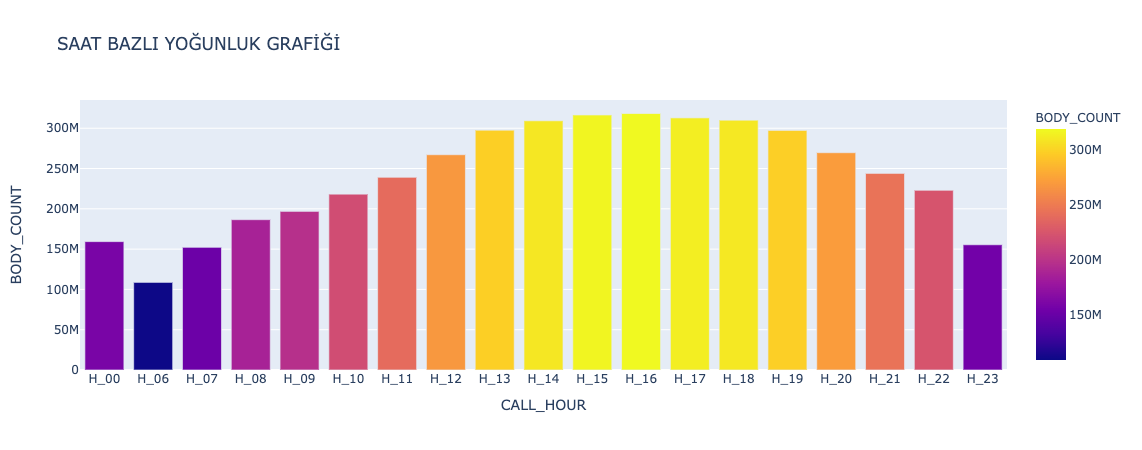

In [42]:
fig = px.bar(df_call_hour.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index(), x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

-----

<h2><center>CALL MONTH DISTRIBUTION</center></h2>

In [18]:
df_group2 = df_new.groupby(['outlet_number','CALL_MONTH'])['BODY_COUNT'].sum()

In [19]:
df_call_month = df_group2.reset_index()

In [20]:
df_call_month.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index().sort_values(by='BODY_COUNT', ascending=False)

,CALL_MONTH,BODY_COUNT
9,November,5.225450e+08
2,December,5.045529e+08
10,October,4.818751e+08
11,September,4.609217e+08
1,August,3.831817e+08
6,June,3.729705e+08
7,March,3.640224e+08
5,July,3.376971e+08
0,April,3.189535e+08
8,May,3.097080e+08


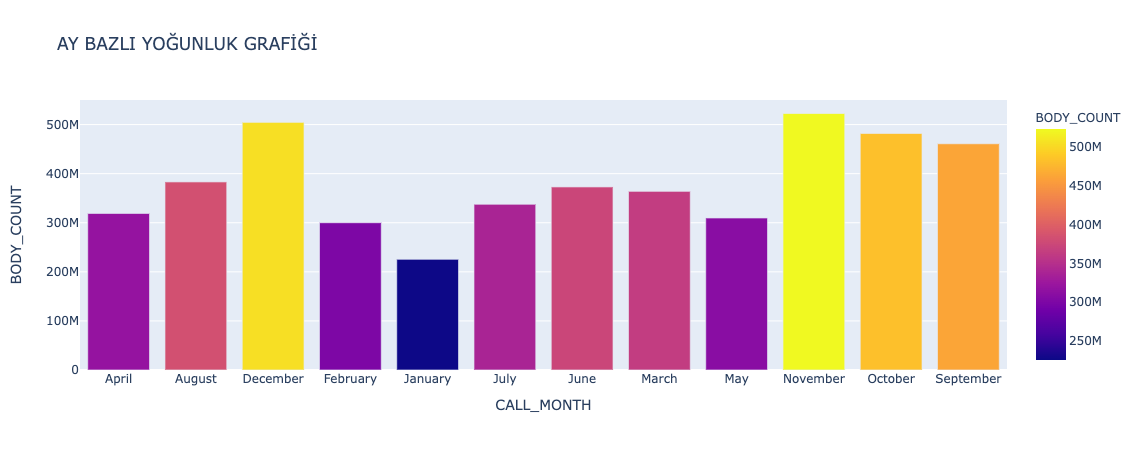

In [43]:
fig = px.bar(df_call_month.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index(), x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title="AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

------

<h2><center>Outlet SubTrade Channel Dist.</center></h2>

In [22]:
df_group3 = df_new.groupby(['outlet_number','outlet_sub_trade_channel_text'])['BODY_COUNT'].sum()

In [23]:
df_sub_trade = df_group3.reset_index()

In [24]:
df_sub_trade.groupby('outlet_sub_trade_channel_text')['BODY_COUNT'].sum().reset_index().sort_values(by='BODY_COUNT', ascending=False)

,outlet_sub_trade_channel_text,BODY_COUNT
5,GROCERY/MOMP-WALK IN,2.587668e+09
2,DRY FRUIT-(ALCOHOL),1.041108e+09
0,BAKERY/PASTRY,3.398504e+08
10,SUPERETTE (50-100 M2,2.717627e+08
3,DRY FRUIT-NONALCOHOL,2.128812e+08
6,KIOSK,6.075531e+07
1,DELICATESSEN,5.508578e+07
9,OTHER SPECIALITYFOOD,6.064664e+06
4,GROCERY/MOMP-COUNTER,4.307087e+06
11,TOBACCO VENDOR/SHOP,1.492567e+06


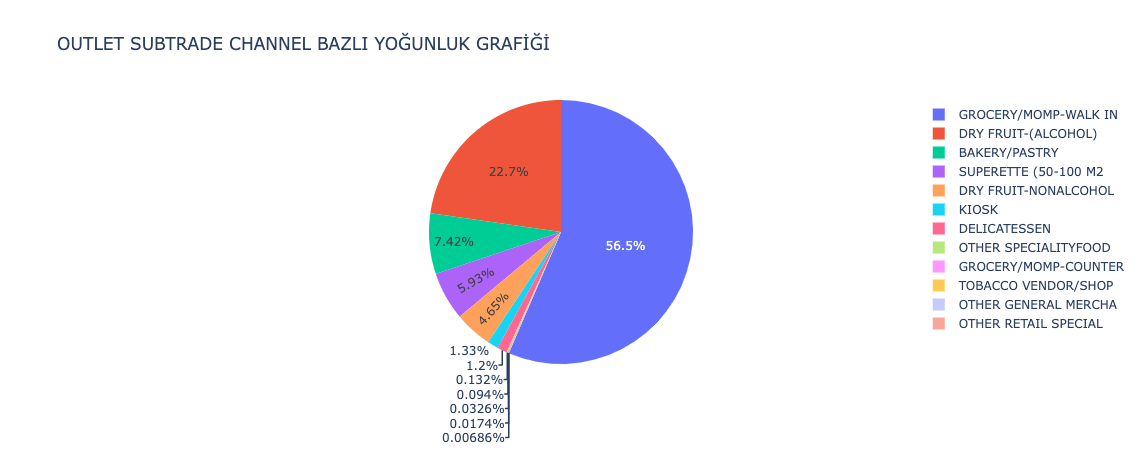

In [50]:
fig = px.pie(df_sub_trade.groupby('outlet_sub_trade_channel_text')['BODY_COUNT'].sum().reset_index(), 
             values='BODY_COUNT', names='outlet_sub_trade_channel_text', title='OUTLET SUBTRADE CHANNEL BAZLI YOĞUNLUK GRAFİĞİ')
fig.show()

----

<h2><center>POI Category Dist.</center></h2>

In [26]:
df_group4 = df_new.groupby(['outlet_number','poi_category'])['BODY_COUNT'].sum()

In [27]:
df_poi_cat = df_group4.reset_index()

In [28]:
df_poi_cat.groupby('poi_category')['BODY_COUNT'].sum().reset_index().sort_values(by='BODY_COUNT', ascending=False)

,poi_category,BODY_COUNT
0,Bakkal/Market,2.890291e+09
10,Tekel Bayi,1.053774e+09
3,Fırın/Pastane,3.581877e+08
4,Gıda Satış/Büfe,1.819230e+08
11,Yeme-İçme/Büfe,6.943434e+07
5,Kafe,1.619268e+07
2,Fast Food,6.428998e+06
6,Lokanta/Kebap,2.708796e+06
9,Simitçi,2.180070e+06
1,Dürümcü,5.819189e+05


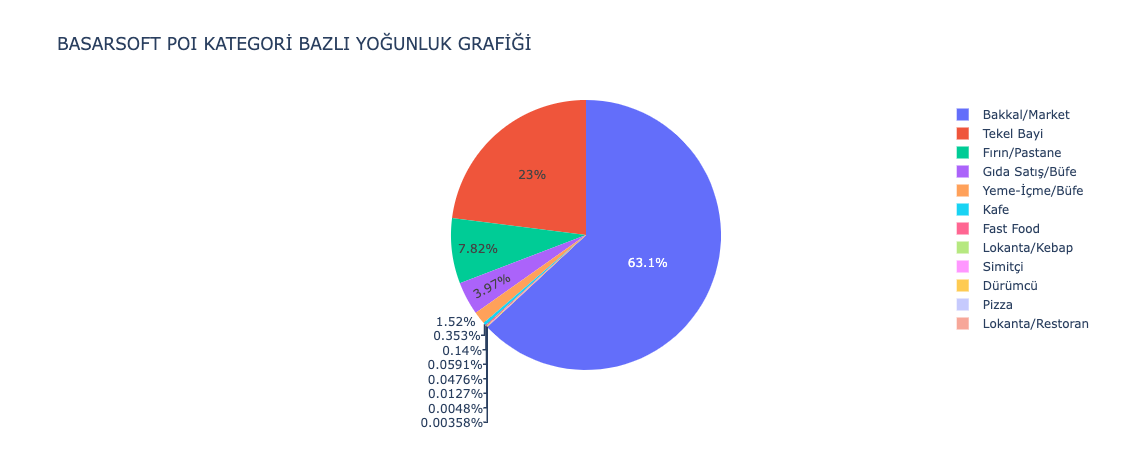

In [49]:
fig = px.pie(df_poi_cat.groupby('poi_category')['BODY_COUNT'].sum().reset_index(), 
             values='BODY_COUNT', names='poi_category', title='BASARSOFT POI KATEGORİ BAZLI YOĞUNLUK GRAFİĞİ')
fig.show()

----

<h2><center>District Name Dist.</center></h2>

In [29]:
df_group5 = df_new.groupby(['outlet_number','district_name'])['BODY_COUNT'].sum()

In [30]:
df_dist = df_group5.reset_index()

In [39]:
df_dist.groupby('district_name')['BODY_COUNT'].sum().reset_index().sort_values(by='BODY_COUNT', ascending=False)

,district_name,BODY_COUNT
15,Esenyurt,3.395100e+08
7,Bağcılar,2.834968e+08
17,Fatih,2.712039e+08
23,Küçükçekmece,2.386418e+08
4,Bahçelievler,2.242934e+08
35,Ümraniye,1.815326e+08
14,Esenler,1.732807e+08
20,Kadıköy,1.598668e+08
32,Zeytinburnu,1.501640e+08
30,Sultangazi,1.474692e+08


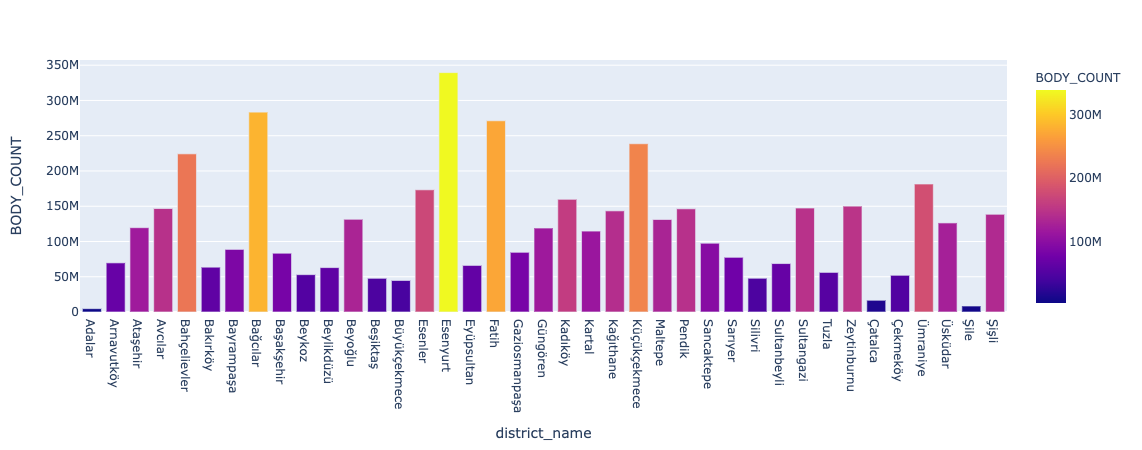

In [37]:
fig = px.bar(df_dist.groupby('district_name')['BODY_COUNT'].sum().reset_index(), x='district_name', y='BODY_COUNT',color="BODY_COUNT")
fig.show()